In [1]:
# Load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import chi2_contingency as chi
from scipy.stats import ttest_ind as ttest
from scipy.stats import mannwhitneyu as mw

from statsmodels.stats import multitest
from statsmodels.stats.proportion import proportion_confint as ci
from statsmodels.stats.weightstats import DescrStatsW

import seaborn as sns

import matplotlib.mlab as mlab

import datetime
import tqdm
import os
import glob
import pickle

from decimal import Decimal
sns.set(style="white")
pd.set_option('display.max_columns', None)
plt.rc('font',family='Times New Roman', size=12)

# Prepare dataset

In [2]:
# Load data as pandas dataframe

########## Read name ###########

list_of_files = glob.glob('./Patients_*.pkl')
list_of_files_1 = glob.glob('./Monitoring_new_features_*.pkl')
latest_file = max(list_of_files, key=os.path.getctime)
latest_file_1 = max(list_of_files_1, key=os.path.getctime)
##########

print("Loading... ",latest_file)
print("Loading... ",latest_file_1)
with open(latest_file, "rb") as f:
    X_prime = pickle.loads(f.read())
with open(latest_file_1, "rb") as f:
    X = pickle.loads(f.read())
print("Done")

Loading...  ./Patients_0922_0640.pkl
Loading...  ./Monitoring_new_features_0922_0640.pkl
Done


___Fill NaNs with mean where appropriate___

In [3]:
for col in ['age', 'mean_FiO2_bi', 'mean_tracheal_sanations_per_day_bi', 'min_RASS_bi',
            'mean_PBSS_bi', 'min_conscious_level_bi', 'max_temperature_bi', 'mean_antibiotics_per_day_bi',
            'days_in_hospital', 'CHARLSON_FIRST']:
    print("Column:\t\t{}\nNaN Values:\t{}\n--".format(col, X_prime.loc[:,col].isnull().values.any()))
    X_prime.loc[:,col] = X_prime.loc[:,col].fillna(X_prime.loc[:,col].mean())

Column:		age
NaN Values:	True
--
Column:		mean_FiO2_bi
NaN Values:	True
--
Column:		mean_tracheal_sanations_per_day_bi
NaN Values:	True
--
Column:		min_RASS_bi
NaN Values:	True
--
Column:		mean_PBSS_bi
NaN Values:	True
--
Column:		min_conscious_level_bi
NaN Values:	True
--
Column:		max_temperature_bi
NaN Values:	True
--
Column:		mean_antibiotics_per_day_bi
NaN Values:	True
--
Column:		days_in_hospital
NaN Values:	True
--
Column:		CHARLSON_FIRST
NaN Values:	True
--


In [4]:
# Make dummies for gender, diagnosis and outcomes

X_prime = pd.get_dummies(X_prime, columns=['gender'], dummy_na=True, drop_first=False)
X_prime = pd.get_dummies(X_prime, columns=['disease_type'], dummy_na=True, drop_first=False)
X_prime = pd.get_dummies(X_prime, columns=['outcome'], dummy_na=True, drop_first=False)

In [5]:
# Add column with info: child (=1) or not (=0)

X_prime.loc[:,'child'] = X_prime.loc[:,'age'].apply(lambda x: 1 if x <=18 else 0)


In [6]:
columns_dict = {
    'EVD_days_bi': 'Days with EVD',
    'ot_device_count_bi': 'Count of INSD',
    'ot_other_count_bi' : 'Count of other surgeries',
    'ot_craniotomy_count_bi' : 'Count of craniotomies',
    'ot_craniotomy_len_sum_bi' : 'Length of all craniotomies, minutes',
    'central_line_days_bi' : 'Days with central line',
    'infection_wound_days_bi' : 'Days with SSSI',
    'X-ray_infiltration_days_bi' : 'Days with lung infiltration on X-ray',
    'age' : 'Age, years',
    'EVD_bi' : 'EVD',
    'ICP_monitor_days_bi' : 'Days with ICP monitoring',
    'ICP_monitor_bi' : 'ICP monitoring',
    'intubation_tube_days_bi' : 'Days with intubation tube',
    'intubation_tube_bi' : 'Intubation tube',
    'most_frequent_intubation_tube_bi' : 'Most frequent type of intubation tube',
    'central_line_bi' : 'Central line',
    'invasive_BP_days_bi' : 'Days with arterial line',
    'invasive_BP_bi' : 'Arterial line',
    'urinary_catheter_bi' : 'Urinary catheter',
    'urinary_catheter_days_bi' : 'Days with urinary catheter',
    'feeding_tube_bi' : 'Feeding tube',
    'feeding_tube_days_bi' : 'Days with feeding tube',
    'pleural_drainage_days_bi' : 'Days with pleural drain',
    'pleural_drainage_bi' : 'Pleural drain',
    'mechanical_ventilation_days_bi' : 'Days with mechanical ventilation',
    'mechanical_ventilation_bi' : 'Mechanical ventilation',
    'hypothermia_days_bi' : 'Days with hypothermia',
    'hypothermia_bi' : 'Hypothermia',
    'hemodialysis_days_bi' :'Days on hemodialysis',
    'hemodialysis_bi' : 'Hemodialysis',
    'total_parenteral_feeding_days_bi' : 'Days with total parenteral feeding',
    'total_parenteral_feeding_bi' : 'Total parenteral feeding',
    'purulent_sputum_bi' : 'Purulent sputum',
    'purulent_sputum_days_bi' : 'Days with purulent sputum',
    'intestinal_dysfunction_days_bi' : 'Days with intestinal dysfunction',
    'intestinal_dysfunction_bi' : 'Intestinal dysfunction',
    'convulsions_day_days_bi' : 'Days with convulsions',
    'convulsions_day_bi' : 'Convulsions',
    'sedation_days_bi' : 'Days with sedation',
    'sedation_bi' : 'Sedation',
    'anxiolytics _days_bi' : 'days with anxiolytics',
    'anxiolytics _bi' : 'Anxiolytics',
    'vasopressors_days_bi' : 'Days with vasopressors',
    'vasopressors_bi' : 'Vasopressors',
    'wound_liquorrhea_days_bi' : 'Days with CSFL-SS',
    'wound_liquorrhea_bi' : 'CSFL-SS',
    'CSF_leakage_days_bi' : 'Days with CSFL-NE',
    'CSF_leakage_bi' : 'CSFL-NE',
    'antibiotics_bi' : 'Antibiotics',
    'CHARLSON_FIRST' : 'CCI',
    'infection_respiratory_days_bi' : 'Days with respiratory infection',
    'infection_respiratory_bi' : 'Respiratory infection',
    'infection_bloodstream_days_bi' : 'Days with bloodstream infection',
    'infection_bloodstream_bi' : 'Bloodstream infection',
    'infection_urinary_days_bi' : 'Days with urinary infection',
    'infection_urinary_bi' : 'Urinary infection',
    'infection_wound_bi' : 'SSSI',
    'infection_other_days_bi' : 'Days with other infections',
    'infection_other_bi' : 'Other infections',
    'ot_endonasal_count_bi' : 'Count of EETS',
    'ot_endovascular_count_bi' : 'Count of endovascular surgeries',
    'ot_spinal_count_bi' : 'Count of spinal surgeries',
    'ot_null_count' : 'No surgeries',
    'ot_craniotomy_count_bi_binary' : 'Craniotomy',
    'ot_device_count_bi_binary' : 'INSD',
    'ot_endonasal_count_bi_binary' : 'EETS',
    'ot_endovascular_count_bi_binary' : 'Endovascular surgery',
    'ot_spinal_count_bi_binary' : 'Spinal surgery',
    'ot_other_count_bi_binary' : 'Other surgeries',
    'ot_device_len_sum_bi' : 'Length of all INSDs, minutes',
    'ot_endonasal_len_sum_bi' : 'Length of all EETSs, minutes',
    'ot_endovascular_len_sum_bi' : 'Length of all endovascular surgeries, minutes',
    'ot_other_len_sum_bi' : 'Length of all other surgeries, minutes',
    'ot_spinal_len_sum_bi' : 'Length of all spinal surgeries',
    'recraniotomy_bi' : 'Recraniotomy',
    'age_int' : 'Age, years',
    'gender_F' : 'Female gender',
    'gender_M' : 'Male gender',
    'disease_type_congenital_disorder' : 'Congenital disorders',
    'disease_type_other' : 'Other diagnosis on admission',
    'disease_type_spinal' : 'Spinal diseases',
    'disease_type_trauma' : 'Head trauma',
    'disease_type_tumor' : 'Brain tumor',
    'disease_type_vascular' : 'Vascular brain diseases'
    }
 

# 1. Descriptive statistics

### General description_1

In [7]:

# TODO:
# Почему infection_CNS_length посчиталась только для 60 человек?

before = X_prime.loc[(X_prime.infection_CNS_1st_day <= 2) & (X_prime.infection_CNS == 1)]
after = X_prime.loc[~(X_prime.infection_CNS_1st_day <= 2) & (X_prime.infection_CNS == 1)]
inf = (X_prime.loc[X_prime.infection_CNS > 0])

statistics = {}

statistics['Number of cases, total'] = (X.ID_1 + X.subid.apply(lambda x: str(x))).unique().shape[0]
statistics['Number of patients, total'] = X.ID_1.unique().shape[0]

statistics['6 Cases Per Patient'] = X.loc[X.cases == 6, 'ID_1'].unique().shape[0]
statistics['3 Cases Per Patient'] = X.loc[X.cases == 3, 'ID_1'].unique().shape[0]
statistics['2 Cases Per Patient'] = X.loc[X.cases == 2, 'ID_1'].unique().shape[0]
statistics['1 Case Per Patient'] = X.loc[X.cases == 1, 'ID_1'].unique().shape[0]

statistics['Patient-days, total'] = X_prime.days_in_ICU_total.sum()

statistics['infection_CNS_length'] = inf.loc[:, ['infection_CNS_length']].describe()

statistics['infection_CNS_1st_day'] = after.loc[:, ['infection_CNS_1st_day']].describe()

statistics['Incidence rate per 1000 patient-days'] = np.around(((len(inf) / X_prime.days_in_ICU_total.sum()) * 1000),
                                                               decimals=2)

statistics = pd.DataFrame.from_dict({'value': statistics})

# Save statistics
statistics.to_csv('general_description_1.csv')
statistics

,value
1 Case Per Patient,2087
2 Cases Per Patient,168
3 Cases Per Patient,30
6 Cases Per Patient,1
Incidence rate per 1000 patient-days,4.71
"Number of cases, total",2519
"Number of patients, total",2286
"Patient-days, total",45862
infection_CNS_1st_day,infection_CNS_1st_day count ...
infection_CNS_length,infection_CNS_length count ...


### General description_2

In [8]:
# Characteristics of all patients

descr = pd.DataFrame(columns=('patients in group', '%', 'CI or std'))

CI = ci(len(inf), X_prime.ID.unique().shape[0], alpha=0.05, method='normal')
descr.loc['Patients with HAVM', 'patients in group'] = len(inf)
descr.loc['Patients with HAVM', '%'] = np.around(((len(inf) / X_prime.ID.unique().shape[0])*100), decimals=2)
descr.loc['Patients with HAVM', 'CI or std'] = str(CI)

CI = ci(before.shape[0], len(inf), alpha=0.05, method='normal')
descr.loc['Patients who developed HAVM before or at 1st day after ICU admission', 'patients in group'] = before.shape[0]
descr.loc['Patients who developed HAVM before or at 1st day after ICU admission', '%'] = np.around(((before.shape[0] /\
                                                                                                     len(inf))*100), decimals=2)
descr.loc['Patients who developed HAVM before or at 1st day after ICU admission', 'CI or std'] = str(CI)

a = after[after.infection_CNS_1st_day <= 7].shape[0]
CI = ci(a, len(inf), alpha=0.05, method='normal')
descr.loc['Pts who developed HAVM at days 2nd to 7th in ICU', 'patients in group'] = a
descr.loc['Pts who developed HAVM at days 2nd to 7th in ICU', '%'] = np.around(((a / len(inf))*100), decimals=2)
descr.loc['Pts who developed HAVM at days 2nd to 7th in ICU', 'CI or std'] = str(CI)

cols_general_descr = ['disease_type_congenital_disorder',
                            'disease_type_other', 'disease_type_spinal',
                            'disease_type_trauma', 'disease_type_tumor',
                            'disease_type_vascular', 'gender_M',
                            'ot_craniotomy_count_binary', 'ot_device_count_binary',
                            'ot_endonasal_count_binary', 'ot_endovascular_count_binary',
                            'ot_other_count_binary', 'ot_null_count_binary',
                            'ot_spinal_count_binary',
                            'outcome_death', 'outcome_negative_dynamics',
                            'outcome_no_dynamics', 'outcome_positive_dynamics',
                            'outcome_recovery', 'child'
                           ]

for col in cols_general_descr:
    a = X_prime.loc[X_prime[col] == 1].shape[0]
    descr.loc[col, 'patients in group'] = a
    descr.loc[col, '%'] = np.around(((a / X.ID_1.unique().shape[0])*100), decimals=2)

cols = ['days_in_ICU_total', 'days_in_hospital', 'CHARLSON_FIRST', 'cases', 'age']

for col in cols:
    descr.loc[col, 'patients in group'] = X_prime.loc[(X_prime[col] != 0), col].mean(skipna=True)
    descr.loc[col, 'CI or std'] = X_prime.loc[(X_prime[col] != 0), col].std(skipna=True)

    
descr.to_csv('general_description_2.csv')

#descr


# 2. Comparison by groups (infected / not infected)

## Groups characteristics

In [9]:
# Function for binary variables (number of patients) and chi-square test

def get_group_statistics(X_prime, factor, row_index):
    m = pd.crosstab(X_prime.loc[:, factor], X_prime.loc[:,'infection_CNS'])
    m_series = pd.Series(m.values.reshape(-1), index=['pts_no_infection_no_factor',
                                                      'pts_infection_no_factor', 'pts_no_infection_factor',
                                                      'pts_infection_factor'])
    p = pd.Series(chi(m)[1], index=['p_value'])
    percentages = pd.Series(((m.loc[1,:] / m.sum(axis=0)).values * 100), index=['pts_no_infection_factor, %',
                                                                              'pts_infection_factor, %'])
    cif = ci(m.loc[1,:],
             m.sum(axis=0),
             alpha=0.05,
             method='normal')
    
    cif = pd.Series([x for x in np.array(cif).T], index=['CI, not-infected', 'CI, infected'])
    res = pd.concat([m_series, p, percentages, cif]).to_frame().T
    res.index = [row_index]
    return res



In [10]:
# Compare binary variables

cols_characteristics_chi = ['disease_type_congenital_disorder',
                            'disease_type_other', 'disease_type_spinal',
                            'disease_type_trauma', 'disease_type_tumor',
                            'disease_type_vascular', 'gender_M',
                            'ot_craniotomy_count_binary', 'ot_device_count_binary',
                            'ot_endonasal_count_binary', 'ot_endovascular_count_binary',
                            'ot_other_count_binary', 'ot_null_count_binary',
                            'ot_spinal_count_binary',
                            'outcome_death', 'outcome_negative_dynamics',
                            'outcome_no_dynamics', 'outcome_positive_dynamics',
                            'outcome_recovery', 'child'
                           ]

characteristics_chi = pd.DataFrame()
for col in cols_characteristics_chi:
    s = get_group_statistics(X_prime, col, col)
    characteristics_chi = pd.concat([characteristics_chi, s])

I = X_prime[X_prime.infection_CNS == 1].shape[0]
N = X_prime[X_prime.infection_CNS != 1].shape[0]
print('Number of patients in infected group; %\t\t', I, ';', "%.2f" %(I/2319*100))
print('Number of patients in not infected group; %\t', N, ';', "%.2f" %(N/2319*100))

#characteristics_chi

Number of patients in infected group; %		 216 ; 9.31
Number of patients in not infected group; %	 2070 ; 89.26


In [11]:
# Compare continuous variables using Mann-Whitney test

cols_char_mw = ['days_in_ICU_total', 'days_in_hospital', 'CHARLSON_FIRST', 'cases', 'age']


char_mw = pd.DataFrame(index = cols_char_mw,
                                  columns = ('mean_infected', 'std_infected','median_infected',
                                             'IQI_infected', 'CI, infected',
                                             'mean_not_infected', 'std_not_infected',
                                             'median_not_infected', 'IQI_not_infected', 'CI, not-infected',
                                             'p_value'))

for factor in cols_char_mw:
    char_mw.loc[factor, 'mean_infected'] = X_prime.loc[(X_prime.infection_CNS == 1)& (X_prime[factor] != 0),factor].mean(skipna=True)
    char_mw.loc[factor, 'std_infected'] = X_prime.loc[(X_prime.infection_CNS == 1)& (X_prime[factor] != 0),factor].std(skipna=True)
    char_mw.loc[factor, 'median_infected'] = X_prime.loc[(X_prime.infection_CNS == 1)& (X_prime[factor] != 0),factor].median(skipna=True)
    char_mw.loc[factor, 'IQI_infected'] = str(X_prime.loc[(X_prime.infection_CNS == 1)& (X_prime[factor] != 0),factor].quantile([.25, .75]))
    d = DescrStatsW(X_prime.loc[(X_prime.infection_CNS == 1), factor])
    char_mw.loc[factor, 'CI, infected'] = d.tconfint_mean()
    
    char_mw.loc[factor, 'mean_not_infected'] = X_prime.loc[(X_prime.infection_CNS != 1)& (X_prime[factor] != 0),factor].mean(skipna=True)
    char_mw.loc[factor, 'std_not_infected'] = X_prime.loc[(X_prime.infection_CNS != 1)& (X_prime[factor] != 0),factor].std(skipna=True)
    char_mw.loc[factor, 'median_not_infected'] = X_prime.loc[(X_prime.infection_CNS != 1)& (X_prime[factor] != 0),factor].median(skipna=True)
    char_mw.loc[factor, 'IQI_not_infected'] = str(X_prime.loc[(X_prime.infection_CNS != 1)& (X_prime[factor] != 0),factor].quantile([.25, .75]))
    d = DescrStatsW(X_prime.loc[(X_prime.infection_CNS != 1), factor])
    char_mw.loc[factor, 'CI, not-infected'] = d.tconfint_mean()
    
    char_mw.loc[factor, 'p_value'] =  mw(X_prime.loc[(X_prime.infection_CNS == 1) & \
                                                        (~X_prime[factor].isnull()) & \
                                                        (X_prime[factor] != 0), factor],
                                              X_prime.loc[(X_prime.infection_CNS != 1) & \
                                                        (~X_prime[factor].isnull()) & \
                                                        (X_prime[factor] != 0), factor])[1]


char_mw

,mean_infected,std_infected,median_infected,IQI_infected,"CI, infected",mean_not_infected,std_not_infected,median_not_infected,IQI_not_infected,"CI, not-infected",p_value
days_in_ICU_total,41.5139,40.8054,29,0.25 15.0\n0.75 51.0\nName: days_in_ICU_...,"(36.0413333066, 46.9864444711)",17.8237,35.054,9,0.25 5.0\n0.75 20.0\nName: days_in_ICU_...,"(16.3127078403, 19.3346351549)",1.35393e-39
days_in_hospital,74.4583,70.4861,51.5,0.25 31.0\n0.75 90.5\nName: days_in_hosp...,"(65.0051931742, 83.9114734924)",36.034,40.4108,25,0.25 16.0\n0.75 41.0\nName: days_in_hosp...,"(34.2921064563, 37.7758385717)",4.51281e-34
CHARLSON_FIRST,3.65672,1.98089,3,0.25 2.00\n0.75 4.25\nName: CHARLSON_FIR...,"(3.09967188861, 3.67202757383)",3.63407,1.97966,3,0.25 2.0\n0.75 5.0\nName: CHARLSON_FIRST...,"(3.24681898687, 3.43143545005)",0.40307
cases,1.2963,0.636257,1,"0.25 1.0\n0.75 1.0\nName: cases, dtype: ...","(1.21096554003, 1.38162705256)",1.08164,0.305581,1,"0.25 1.0\n0.75 1.0\nName: cases, dtype: ...","(1.0684707741, 1.09481425006)",4.53863e-15
age,41.559,20.3261,46,"0.25 24.75\n0.75 56.00\nName: age, dtype...","(38.83301905, 44.2850365055)",41.9831,21.4413,46,"0.25 26.0\n0.75 59.0\nName: age, dtype: ...","(41.0588728358, 42.9072811275)",0.280224


#### Correction for multiple comparisons

In [12]:
characteristics = pd.concat([characteristics_chi, char_mw], axis=0)

pvalues = characteristics.loc[:, 'p_value']

p_adjusted = multitest.multipletests(pvalues, alpha=0.05, method='holm')[1]
characteristics.loc[:, 'p_adjusted'] = p_adjusted
characteristics.to_csv('groups_characteristics.csv')
#characteristics

In [13]:
# Check p-values >0.01
characteristics.loc[(characteristics.p_adjusted < 0.01)]

,"CI, infected","CI, not-infected",IQI_infected,IQI_not_infected,mean_infected,mean_not_infected,median_infected,median_not_infected,p_value,pts_infection_factor,"pts_infection_factor, %",pts_infection_no_factor,pts_no_infection_factor,"pts_no_infection_factor, %",pts_no_infection_no_factor,std_infected,std_not_infected,p_adjusted
ot_device_count_binary,"[0.603800792551, 0.729532540782]","[0.251394347951, 0.289668453981]",NaN,NaN,NaN,NaN,NaN,NaN,8.96122e-33,144,66.6667,72,560,27.0531,1510,NaN,NaN,2.06108e-31
ot_endonasal_count_binary,"[0.0653466202259, 0.147616342737]","[0.028613540956, 0.0448164107349]",NaN,NaN,NaN,NaN,NaN,NaN,3.87673e-06,23,10.6481,193,76,3.6715,1994,NaN,NaN,7.36579e-05
ot_other_count_binary,"[0.642809038756, 0.764598368652]","[0.373151235001, 0.415254562101]",NaN,NaN,NaN,NaN,NaN,NaN,3.69217e-18,152,70.3704,64,816,39.4203,1254,NaN,NaN,8.12278e-17
outcome_death,"[0.231051199809, 0.352282133524]","[0.115926677027, 0.14494288819]",NaN,NaN,NaN,NaN,NaN,NaN,3.16395e-10,63,29.1667,153,270,13.0435,1800,NaN,NaN,6.3279e-09
outcome_positive_dynamics,"[0.270467459218, 0.396199207449]","[0.448547623672, 0.491548994686]",NaN,NaN,NaN,NaN,NaN,NaN,0.000165628,72,33.3333,144,973,47.0048,1097,NaN,NaN,0.00298131
days_in_ICU_total,"(36.0413333066, 46.9864444711)","(16.3127078403, 19.3346351549)",0.25 15.0\n0.75 51.0\nName: days_in_ICU_...,0.25 5.0\n0.75 20.0\nName: days_in_ICU_...,41.5139,17.8237,29,9,1.35393e-39,NaN,NaN,NaN,NaN,NaN,NaN,40.8054,35.054,3.38482e-38
days_in_hospital,"(65.0051931742, 83.9114734924)","(34.2921064563, 37.7758385717)",0.25 31.0\n0.75 90.5\nName: days_in_hosp...,0.25 16.0\n0.75 41.0\nName: days_in_hosp...,74.4583,36.034,51.5,25,4.51281e-34,NaN,NaN,NaN,NaN,NaN,NaN,70.4861,40.4108,1.08308e-32
cases,"(1.21096554003, 1.38162705256)","(1.0684707741, 1.09481425006)","0.25 1.0\n0.75 1.0\nName: cases, dtype: ...","0.25 1.0\n0.75 1.0\nName: cases, dtype: ...",1.2963,1.08164,1,1,4.53863e-15,NaN,NaN,NaN,NaN,NaN,NaN,0.636257,0.305581,9.53111e-14


## Univariate analysis of risk factors
### Take only _bi variables

In [14]:
# Drop all patients who got meningitis in the first day of observation

X_uni = X_prime.copy()
X_uni = X_uni.loc[~(X_uni.infection_CNS_1st_day <= 2)]
X_uni.shape

(2248, 247)

In [15]:

cols_uni_chi = ['EVD_bi', 'ICP_monitor_bi', 'intubation_tube_bi',
                'central_line_bi', 'invasive_BP_bi',
                'urinary_catheter_bi', 'feeding_tube_bi', 'pleural_drainage_bi',
                'mechanical_ventilation_bi', 'hypothermia_bi', 'hemodialysis_bi',
                'total_parenteral_feeding_bi', 'purulent_sputum_bi', 'X-ray_infiltration_bi',
                'intestinal_dysfunction_bi', 'convulsions_day_bi', 'sedation_bi',
                'anxiolytics _bi', 'vasopressors_bi',
                'wound_liquorrhea_bi', 'CSF_leakage_bi', 'antibiotics_bi',
                'infection_respiratory_bi', 'infection_bloodstream_bi',
                'infection_urinary_bi', 'infection_wound_bi', 'infection_other_bi',
                'ot_craniotomy_count_bi_binary', 'ot_device_count_bi_binary',
                'ot_endonasal_count_bi_binary', 'ot_endovascular_count_bi_binary',
                'ot_other_count_bi_binary', 'ot_spinal_count_bi_binary', 'recraniotomy_bi']


uni_chi = pd.DataFrame()

for col in cols_uni_chi:
    s = get_group_statistics(X_uni, col, col)
    uni_chi = pd.concat([uni_chi, s])
    
I = X_uni[X_uni.infection_CNS == 1].shape[0]
N = X_uni[X_uni.infection_CNS != 1].shape[0]
print('Number of patients in infected group; %\t\t', I, ';', "%.2f" %(I/len(X_prime)*100))
print('Number of patients in not infected group; %\t', N, ';', "%.2f" %(N/len(X_prime)*100))
#uni_chi

Number of patients in infected group; %		 178 ; 7.79
Number of patients in not infected group; %	 2070 ; 90.55


In [16]:
# Compare continuous variables using using mann-whitney test

cols_uni_mw = ['EVD_days_bi', 'ICP_monitor_days_bi',
                 'intubation_tube_days_bi', 'central_line_days_bi', 'invasive_BP_days_bi',
                 'urinary_catheter_days_bi', 'feeding_tube_days_bi',
                 'pleural_drainage_days', 'pleural_drainage_days_bi',
                 'mechanical_ventilation_days_bi', 'hypothermia_days_bi', 'hemodialysis_days_bi',
                 'total_parenteral_feeding_days_bi', 'purulent_sputum_days_bi', 'X-ray_infiltration_days_bi',
                 'intestinal_dysfunction_days_bi', 'convulsions_day_days_bi', 'sedation_days_bi',
                 'anxiolytics _days_bi', 'vasopressors_days_bi', 'wound_liquorrhea_days_bi',
                 'CSF_leakage_days_bi', 'infection_respiratory_days_bi',
                 'infection_bloodstream_days_bi', 'infection_urinary_days_bi',
                 'infection_wound_days_bi', 'infection_other_days_bi',
                 'mean_tracheal_sanations_per_day_bi',
                 'ot_craniotomy_count_bi', 'ot_device_count_bi', 'ot_endonasal_count_bi',
                 'ot_endovascular_count_bi', 'ot_other_count_bi', 'ot_spinal_count_bi',
                 'ot_craniotomy_len_sum_bi', 'ot_device_len_sum_bi', 'ot_endonasal_len_sum_bi',
                 'ot_endovascular_len_sum_bi', 'ot_other_len_sum_bi', 'ot_spinal_len_sum_bi']
            
                 
uni_mw = pd.DataFrame(index=cols_uni_mw,
                        columns=('mean_infected', 'std_infected','median_infected',
                                  'IQI_infected', 'CI, infected',
                                  'mean_not_infected', 'std_not_infected',
                                  'median_not_infected', 'IQI_not_infected', 'CI, not-infected',
                                  'p_value'))
                      
for factor in cols_uni_mw:
    uni_mw.loc[factor, 'mean_infected'] = X_uni.loc[(X_prime.infection_CNS == 1)& (X_uni[factor] != 0), factor].mean(skipna=True)
    uni_mw.loc[factor, 'std_infected'] = X_uni.loc[(X_prime.infection_CNS == 1)& (X_uni[factor] != 0), factor].std(skipna=True)
    uni_mw.loc[factor, 'median_infected'] = X_uni.loc[(X_prime.infection_CNS == 1)& (X_uni[factor] != 0), factor].median(skipna=True)
    uni_mw.loc[factor, 'IQI_infected'] = str(X_uni.loc[(X_prime.infection_CNS == 1)& (X_uni[factor] != 0), factor].quantile([.25, .75]))
    
    d = DescrStatsW(X_uni.loc[(X_uni.infection_CNS == 1)&(~X_uni[factor].isnull()) & (X_uni[factor] != 0), factor])
    uni_mw.loc[factor, 'CI, infected'] = d.tconfint_mean()
    
    uni_mw.loc[factor, 'mean_not_infected'] = X_uni.loc[(X_prime.infection_CNS != 1)& (X_uni[factor] != 0), factor].mean(skipna=True)
    uni_mw.loc[factor, 'std_not_infected'] = X_uni.loc[(X_prime.infection_CNS != 1)& (X_uni[factor] != 0), factor].std(skipna=True)
    uni_mw.loc[factor, 'median_not_infected'] = X_uni.loc[(X_prime.infection_CNS != 1)& (X_uni[factor] != 0), factor].median(skipna=True)
    uni_mw.loc[factor, 'IQI_not_infected'] = str(X_uni.loc[(X_prime.infection_CNS != 1)& (X_uni[factor] != 0), factor].quantile([.25, .75]))
    
    d = DescrStatsW(X_uni.loc[(X_uni.infection_CNS != 1)&(~X_uni[factor].isnull())&(X_uni[factor] != 0), factor])
    uni_mw.loc[factor, 'CI, not-infected'] = d.tconfint_mean()
    
    uni_mw.loc[factor, 'p_value'] = mw(X_uni.loc[(X_uni.infection_CNS == 1) & \
                                                        (~X_uni[factor].isnull()) & \
                                                        (X_uni[factor] != 0), factor],
                                              X_uni.loc[(X_uni.infection_CNS != 1) & \
                                                        (~X_uni[factor].isnull()) & \
                                                        (X_uni[factor] != 0), factor])[1]
#uni_mw

/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/stats/weightstats.py:132: RuntimeWarning: invalid value encountered in double_scalars
  return self.sum / self.sum_weights
/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/stats/weightstats.py:179: RuntimeWarning: invalid value encountered in double_scalars
  return self.sumsquares / (self.sum_weights - self.ddof)
/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/stats/weightstats.py:224: RuntimeWarning: invalid value encountered in sqrt
  return std / np.sqrt(self.sum_weights - 1)
/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:4879: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd
/Users/ksun/anaconda3/envs/py35/lib/python3.5/site-packages/statsmodels/stats/weightstats.py:224: RuntimeWarning: invalid value encountered in double_scalars
  return std / np.sqrt(self.sum_weights - 1)


#### Correction for multiple comparisons

In [17]:
univariate = pd.concat([uni_chi, uni_mw], axis=0)

pvalues = univariate.loc[:, 'p_value']

p_adjusted = multitest.multipletests(pvalues, alpha=0.05, method='holm')[1]
univariate.loc[:, 'p_adjusted'] = p_adjusted

# Save characteristics table
univariate.to_csv('univariate_analysis.csv')
univariate.shape
#univariate

(74, 18)

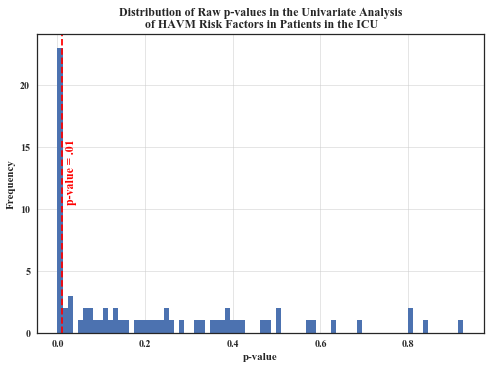

In [18]:
# Plot p-value distribution

univariate.p_value.plot.hist(bins=80)
plt.axvline(x=0.01, color='r', linestyle='--')
plt.text(0.02, 15,'p-value = .01', color='r', rotation=90)
plt.grid(b=True, which='major', axis='both',alpha=0.5)
plt.xlabel('p-value')
plt.title('Distribution of Raw p-values in the Univariate Analysis\n of HAVM Risk Factors in Patients in the ICU')

plt.savefig('./final_plots/p-values.pdf', dpi=600)

In [19]:
# Check significant factors

signif = univariate.loc[(univariate.p_adjusted < 0.01) & (univariate.p_adjusted != 0)]
signif.to_csv('./univariate_significant.csv')
signif

,"CI, infected","CI, not-infected",IQI_infected,IQI_not_infected,mean_infected,mean_not_infected,median_infected,median_not_infected,p_value,pts_infection_factor,"pts_infection_factor, %",pts_infection_no_factor,pts_no_infection_factor,"pts_no_infection_factor, %",pts_no_infection_no_factor,std_infected,std_not_infected,p_adjusted
EVD_bi,"[0.471788407619, 0.61809923283]","[0.235822977402, 0.273355766559]",NaN,NaN,NaN,NaN,NaN,NaN,2.14113e-16,97,54.4944,81,527,25.4589,1543,NaN,NaN,1.54161e-14
central_line_bi,"[0.814993922005, 0.915343156647]","[0.937721454528, 0.95696453581]",NaN,NaN,NaN,NaN,NaN,NaN,1.75811e-05,154,86.5169,24,1961,94.7343,109,NaN,NaN,0.00114277
wound_liquorrhea_bi,"[0.0568327132395, 0.145414477772]","[0.0204868362029, 0.0345856275652]",NaN,NaN,NaN,NaN,NaN,NaN,4.94024e-07,18,10.1124,160,57,2.75362,2013,NaN,NaN,3.35936e-05
CSF_leakage_bi,"[0.108670039413, 0.217172657216]","[0.05458086198, 0.0758539206287]",NaN,NaN,NaN,NaN,NaN,NaN,3.16656e-06,29,16.2921,149,135,6.52174,1935,NaN,NaN,0.000212159
infection_wound_bi,"[0.0613794418503, 0.152103704217]","[0.0183792995414, 0.0318622463523]",NaN,NaN,NaN,NaN,NaN,NaN,8.83717e-09,19,10.6742,159,52,2.51208,2018,NaN,NaN,6.18602e-07
ot_device_count_bi_binary,"[0.529188777239, 0.673058413773]","[0.251394347951, 0.289668453981]",NaN,NaN,NaN,NaN,NaN,NaN,4.32079e-20,107,60.1124,71,560,27.0531,1510,NaN,NaN,3.15418e-18
ot_other_count_bi_binary,"[0.575818878984, 0.716315952476]","[0.373151235001, 0.415254562101]",NaN,NaN,NaN,NaN,NaN,NaN,9.99921e-11,115,64.6067,63,816,39.4203,1254,NaN,NaN,7.09944e-09
recraniotomy_bi,"[0.183819097117, 0.310562925355]","[0.115926677027, 0.14494288819]",NaN,NaN,NaN,NaN,NaN,NaN,2.67678e-05,44,24.7191,134,270,13.0435,1800,NaN,NaN,0.00171314
X-ray_infiltration_days_bi,"(5.37089423122, 8.51372115339)","(10.703488269, 12.496511731)",0.25 2.0\n0.75 9.0\nName: X-ray_infiltra...,0.25 5.0\n0.75 15.0\nName: X-ray_infilt...,6.94231,11.6,7,9,0.000115707,NaN,NaN,NaN,NaN,NaN,NaN,5.64441,10.0483,0.00728952
infection_respiratory_days_bi,"(5.6560090746, 8.79560382863)","(11.0205418404, 12.7416731433)",0.25 2.25\n0.75 9.75\nName: infection_re...,0.25 5.0\n0.75 15.0\nName: infection_re...,7.22581,11.8811,7,9,0.000120543,NaN,NaN,NaN,NaN,NaN,NaN,6.18146,10.8583,0.00747365


In [20]:
cols_to_hist = ['EVD_days_bi', 'ot_device_count_bi', 'ot_other_count_bi',
                'ot_craniotomy_count_bi',
                'ot_craniotomy_len_sum_bi', 'central_line_days_bi',
                'infection_wound_days_bi', 'X-ray_infiltration_days_bi', 'age']

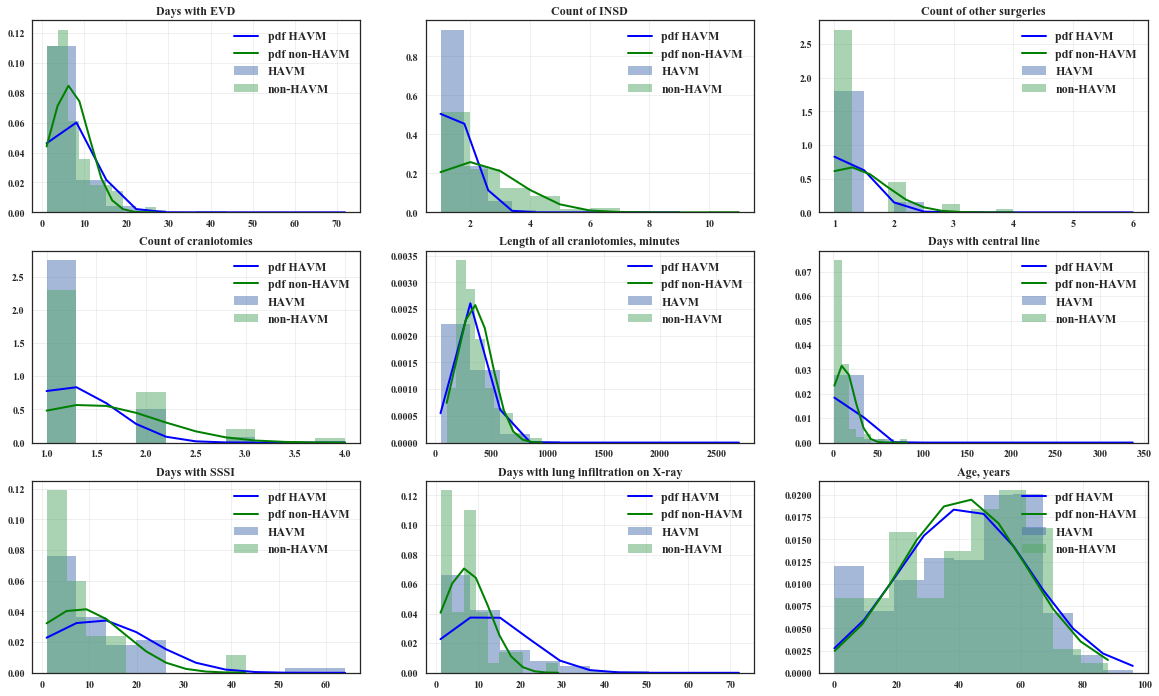

In [21]:
g = X_prime.loc[:, cols_to_hist]
g = g.fillna(0)

kwargs = dict(histtype='stepfilled', alpha=0.5, normed=True)

i = 1
plt.figure(figsize=(20, 12))
for col in g.columns:
    plt.subplot(3, 3, i)
    i += 1
    mu = g.loc[(X_prime.infection_CNS == 0) & (g[col] > 0), col].describe()[1]
    sigma = g.loc[(X_prime.infection_CNS == 0) & (g[col] > 0), col].describe()[2]
    count, bins, ignored = plt.hist((g.loc[(X_prime.infection_CNS == 0) & (g[col] > 0), col]), **kwargs, label=col)
    
    y = mlab.normpdf( bins, mu, sigma)
    plt.plot(bins, y, 'b', linewidth=2)
 
    
    mu = g.loc[(X_prime.infection_CNS != 0) & (g[col] > 0), col].describe()[1]
    sigma = g.loc[(X_prime.infection_CNS != 0) & (g[col] > 0), col].describe()[2]
    count, bins, ignored = plt.hist((g.loc[(X_prime.infection_CNS != 0) & (g[col] > 0), col]), **kwargs)
    y = mlab.normpdf(bins, mu, sigma)

    plt.plot(bins, y, 'g', linewidth=2)
    
    
    plt.legend(loc='best', labels=('pdf HAVM', 'pdf non-HAVM', 'HAVM', 'non-HAVM'), fontsize='12')
    plt.title(columns_dict.get(col))
    plt.axis('tight')
    plt.grid(b=True, which='major', axis='both',alpha=0.3)

plt.savefig('./final_plots/histograms.pdf', dpi=600)
plt.show()


# 3. Incidence and relative risk

In [22]:
factors = ['EVD', 'ICP_monitor', 'invasive_BP', 'urinary_catheter', 'feeding_tube',
           'mechanical_ventilation', 'CSF_leakage', 'wound_liquorrhea', 'infection_wound', 
           'infection_respiratory', 'infection_urinary', 'infection_bloodstream']

incidence = pd.DataFrame()

for factor in factors:
    PTS_WITHOUT_FACTOR = X_prime.loc[(X_prime[factor] !=1)].shape[0]
    PTS_WITH_FACTOR = X_prime.loc[(X_prime[factor] ==1)].shape[0]
    INFECTION_ASSOC_FACTOR = X_prime[X_prime[factor + '_1st_day'] < X_prime.infection_CNS_1st_day].shape[0]
    INFECTION_NOT_ASSOC_FACTOR = X_prime[X_prime[factor + '_1st_day'] >= X_prime.infection_CNS_1st_day].shape[0]
    
    NO_INFECTION_FACTOR = X_prime.loc[(X_prime.infection_CNS != 1) & (X_prime[factor] == 1)].shape[0]
    INFECTION_NO_FACTOR = X_prime.loc[(X_prime.infection_CNS == 1) & (X_prime[factor] != 1)].shape[0]
    NO_INFECTION_NO_FACTOR = X_prime.loc[(X_prime.infection_CNS != 1) & (X_prime[factor] != 1)].shape[0]
    
    incidence.loc['Patients without factor', factor] = PTS_WITHOUT_FACTOR
    
    incidence.loc['Patients with factor', factor] = PTS_WITH_FACTOR
    
    incidence.loc['Patients NO Infection, NO factor', factor] = NO_INFECTION_NO_FACTOR
    
    incidence.loc['Patients NO Infection, with factor', factor] = NO_INFECTION_FACTOR
    
    incidence.loc['Patients with Infection, NO factor', factor] = INFECTION_NO_FACTOR
    
    incidence.loc['Patients with infection, associated with factor', factor] = INFECTION_ASSOC_FACTOR

    incidence.loc['Patients with infection, not associated with factor', factor] = INFECTION_NOT_ASSOC_FACTOR

    incidence.loc['Incidence with factor', factor] = (INFECTION_ASSOC_FACTOR / PTS_WITH_FACTOR)*100
    
    incidence.loc['CI, incidence with factor', factor] = str(ci(INFECTION_ASSOC_FACTOR, PTS_WITH_FACTOR,
                                                                alpha=0.05, method='normal'))

    incidence.loc['Incidence NO factor', factor] = (INFECTION_NO_FACTOR / PTS_WITHOUT_FACTOR)*100
    
    incidence.loc['CI, incidence NO factor', factor] = str(ci(INFECTION_NO_FACTOR, PTS_WITHOUT_FACTOR,
                                                              alpha=0.05, method='normal'))

    incidence.loc['Relative risk', factor] = (INFECTION_ASSOC_FACTOR / PTS_WITH_FACTOR) /\
    (INFECTION_NO_FACTOR / PTS_WITHOUT_FACTOR)
    
    incidence.loc['Total days with factor', factor] = X_prime[factor + '_days'].sum()
    
    incidence.loc['Incidence of factor-associated infection per 1000 device-days', factor] = (INFECTION_ASSOC_FACTOR /\
                                                                       X_prime[factor + '_days'].sum()) * 1000
    
    incidence.loc['p-value', factor] = chi(np.array([[PTS_WITH_FACTOR, INFECTION_ASSOC_FACTOR],
                                                    [PTS_WITHOUT_FACTOR, INFECTION_NO_FACTOR]]))[1]


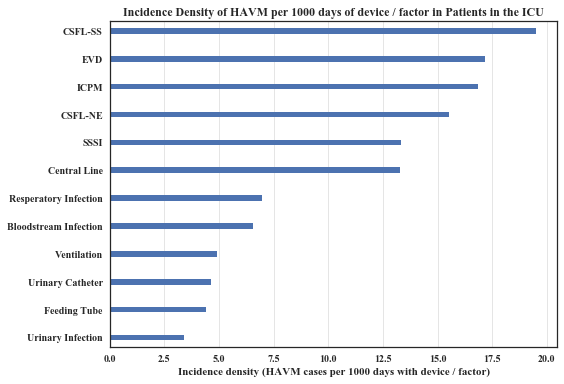

In [23]:
ticks = ['CSFL-SS', "EVD", 'ICPM', 'CSFL-NE', 'SSSI', 'Central Line', 
         'Resperatory Infection', 'Bloodstream Infection', 'Ventilation',
         'Urinary Catheter', 'Feeding Tube', 'Urinary Infection']
fig, ax = plt.subplots()

incidence.loc['Incidence of factor-associated infection per 1000 device-days', :].sort_values().plot(kind='barh',
                                                                                        width=0.2, ax=ax)

ax.set_yticklabels(ticks[::-1])
plt.xlabel('Incidence density (HAVM cases per 1000 days with device / factor)')
plt.title('Incidence Density of HAVM per 1000 days of device / factor in Patients in the ICU')

plt.grid(b=True, which='major', axis='x',alpha=0.5)
plt.tight_layout()

plt.savefig('./final_plots/incidence_DD.pdf', dpi=600)

In [24]:
# Add surgeries
ots = ('ot_craniotomy', 'ot_device', 'ot_endovascular', 'ot_spinal', 'ot_endonasal')

for ot in ots:
    
    PTS_WITHOUT_OT = X_prime.loc[(X_prime[ot + '_count_binary'] !=1)].shape[0]
    PTS_WITH_OT = X_prime.loc[(X_prime[ot + '_count_binary'] ==1)].shape[0]
    INFECTION_ASSOC_OT = X_prime.loc[(X_prime[ot + '_count_bi_binary'] ==1) & (X_prime.infection_CNS ==1)].shape[0]
    INFECTION_NOT_ASSOC_OT = X_prime.loc[(X_prime[ot + '_count_bi_binary'] !=1) &\
                                             (X_prime.infection_CNS ==1)].shape[0]
    
    NO_INFECTION_OT = X_prime.loc[(X_prime.infection_CNS != 1) & (X_prime[ot + '_count_binary'] == 1)].shape[0]
    INFECTION_NO_OT = X_prime.loc[(X_prime.infection_CNS == 1) & (X_prime[ot + '_count_binary'] != 1)].shape[0]
    NO_INFECTION_NO_OT = X_prime.loc[(X_prime.infection_CNS != 1) & (X_prime[ot + '_count_binary'] != 1)].shape[0]
    
    
    incidence.loc['Patients without factor', ot] = PTS_WITHOUT_OT
    
    incidence.loc['Patients with factor', ot] = PTS_WITH_OT
    
    incidence.loc['Patients NO Infection, NO factor', ot] = NO_INFECTION_NO_OT
    
    incidence.loc['Patients NO Infection, with factor', ot] = NO_INFECTION_OT
    
    incidence.loc['Patients with Infection, NO factor', ot] = INFECTION_NO_OT
    
    incidence.loc['Patients with infection, associated with factor', ot] = INFECTION_ASSOC_OT

    incidence.loc['Patients with infection, not associated with factor', ot] = INFECTION_NOT_ASSOC_OT

    incidence.loc['Incidence with factor', ot] = (INFECTION_ASSOC_OT / PTS_WITH_OT)*100
    
    incidence.loc['CI, incidence with factor', ot] = str(ci(INFECTION_ASSOC_OT, PTS_WITH_OT,
                                                                alpha=0.05, method='normal'))

    incidence.loc['Incidence NO factor', ot] = (INFECTION_NO_OT / PTS_WITHOUT_OT)*100
    
    incidence.loc['CI, incidence NO factor', ot] = str(ci(INFECTION_NO_OT, PTS_WITHOUT_OT,
                                                              alpha=0.05, method='normal'))

    incidence.loc['Relative risk', ot] = (INFECTION_ASSOC_OT / PTS_WITH_OT) /\
    (INFECTION_NO_OT / PTS_WITHOUT_OT)
    
    incidence.loc['p-value', ot] = chi(np.array([[PTS_WITH_OT, INFECTION_ASSOC_OT],
                                                    [PTS_WITHOUT_OT, INFECTION_NO_OT]]))[1]


incidence.to_csv('incidence_risk_factors.csv')

In [25]:
# Calculate combined relative risk of meningitis with EVD & other factors

factors_1 = ['CSF_leakage', 'ICP_monitor', 'wound_liquorrhea', 'infection_wound']

combined = pd.DataFrame()

for factor in factors_1:
    NO_EVD_NO_FACTOR = X_prime.loc[(X_prime[factor] !=1) & (X_prime.EVD !=1)].shape[0]
    EVD_NO_FACTOR = X_prime.loc[(X_prime[factor] !=1) & (X_prime.EVD ==1)].shape[0]
    NO_EVD_FACTOR = X_prime.loc[(X_prime[factor] ==1) & (X_prime.EVD !=1)].shape[0]
    EVD_FACTOR = X_prime.loc[(X_prime[factor] ==1) & (X_prime.EVD ==1)].shape[0]
    
    NO_INFECTION_NO_EVD_NO_FACTOR = X_prime.loc[(X_prime.infection_CNS != 1) &
                                                (X_prime[factor] != 1) & (X_prime.EVD !=1)].shape[0]
    NO_INFECTION_EVD_NO_FACTOR = X_prime.loc[(X_prime.infection_CNS != 1) &
                                             (X_prime[factor] != 1) & (X_prime.EVD ==1)].shape[0]
    NO_INFECTION_NO_EVD_FACTOR = X_prime.loc[(X_prime.infection_CNS != 1) & (X_prime[factor] ==1) &
                                           (X_prime.EVD !=1)].shape[0]
    NO_INFECTION_EVD_FACTOR = X_prime.loc[(X_prime.infection_CNS != 1) & (X_prime[factor] ==1) &
                                           (X_prime.EVD ==1)].shape[0]
    
    
    INFECTION_NO_EVD_NO_FACTOR = X_prime.loc[(X_prime.infection_CNS == 1) & (X_prime[factor] != 1) &
                                             (X_prime.EVD !=1)].shape[0]
    INFECTION_NO_EVD_FACTOR = X_prime.loc[(X_prime.infection_CNS == 1) & (X_prime[factor] ==1) &\
                                          (X_prime.EVD !=1)&\
                                          (X_prime[factor +'_1st_day'] < X_prime.infection_CNS_1st_day)].shape[0]
    INFECTION_EVD_NO_FACTOR = X_prime.loc[(X_prime.infection_CNS == 1) &
                                          (X_prime[factor] != 1) & (X_prime.EVD ==1) &\
                                          (X_prime['EVD_1st_day'] < X_prime.infection_CNS_1st_day)].shape[0]
 
    INFECTION_ASSOC_EVD_FACTOR = X_prime.loc[(X_prime[factor + '_1st_day'] < X_prime.infection_CNS_1st_day) &\
                                             (X_prime.EVD ==1) & (X_prime.infection_CNS == 1) &\
                                             (X_prime[factor] ==1) &\
                                             (X_prime['EVD_1st_day'] < X_prime.infection_CNS_1st_day)].shape[0]
    
    INFECTION_NOT_ASSOC_EVD_FACTOR = X_prime.loc[(X_prime[factor + '_1st_day'] >= X_prime.infection_CNS_1st_day) &\
                                                 (X_prime.EVD !=1) & (X_prime.infection_CNS == 1) &\
                                                 (X_prime[factor] !=1) &\
                                                 (X_prime['EVD_1st_day'] >= X_prime.infection_CNS_1st_day)].shape[0]
    
    


    combined.loc['Patients NO EVD, NO factor', factor] = NO_EVD_NO_FACTOR

    combined.loc['Patients with EVD, NO factor', factor] = EVD_NO_FACTOR

    combined.loc['Patients NO EVD, with factor', factor] = NO_EVD_FACTOR
        
    combined.loc['Patients with EVD, with factor', factor] = EVD_FACTOR

    combined.loc['Patients NO Infection, NO EVD, NO factor', factor] = NO_INFECTION_NO_EVD_NO_FACTOR
    
    combined.loc['Patients NO Infection, with EVD, NO factor', factor] = NO_INFECTION_EVD_NO_FACTOR

    combined.loc['Patients NO Infection, NO EVD, with factor', factor] = NO_INFECTION_NO_EVD_FACTOR
    
    combined.loc['Patients NO Infection, with EVD, with factor', factor] = NO_INFECTION_EVD_FACTOR
    
    combined.loc['Patients with Infection, NO EVD, NO factor', factor] = INFECTION_NO_EVD_NO_FACTOR
    
    combined.loc['Patients with Infection, with EVD, NO factor', factor] = INFECTION_EVD_NO_FACTOR
    
    combined.loc['Patients with Infection, NO EVD, with factor', factor] = INFECTION_NO_EVD_FACTOR

    combined.loc['Patients with Infection, associated with EVD, AND with factor', factor] = INFECTION_ASSOC_EVD_FACTOR
    
    IN1 = INFECTION_ASSOC_EVD_FACTOR / EVD_FACTOR
    IN2 = INFECTION_NO_EVD_NO_FACTOR / NO_EVD_NO_FACTOR

    combined.loc['Incidence with factor', factor] = (IN1*100)
    
    combined.loc['CI, incidence with factor', factor] = str(ci(INFECTION_ASSOC_EVD_FACTOR,
                                                                         EVD_FACTOR, alpha=0.05, method='normal'))

    combined.loc['Incidence NO factor', factor] = (IN2*100)
    
    combined.loc['CI, incidence NO factor', factor] = str(ci(INFECTION_NO_EVD_NO_FACTOR,
                                                                         NO_EVD_NO_FACTOR, alpha=0.05, method='normal'))

    
    combined.loc['Relative risk', factor] = ((IN1) / (IN2))
    
    combined.loc['p-value', factor] = chi(np.array([[EVD_FACTOR, INFECTION_ASSOC_EVD_FACTOR],
                                                    [NO_EVD_NO_FACTOR, INFECTION_NO_EVD_NO_FACTOR]]))[1]

    
# Rename columns
combined = combined.add_suffix('_AND_EVD')
combined.to_csv('incidence_combined_risk_factors.csv')

#combined

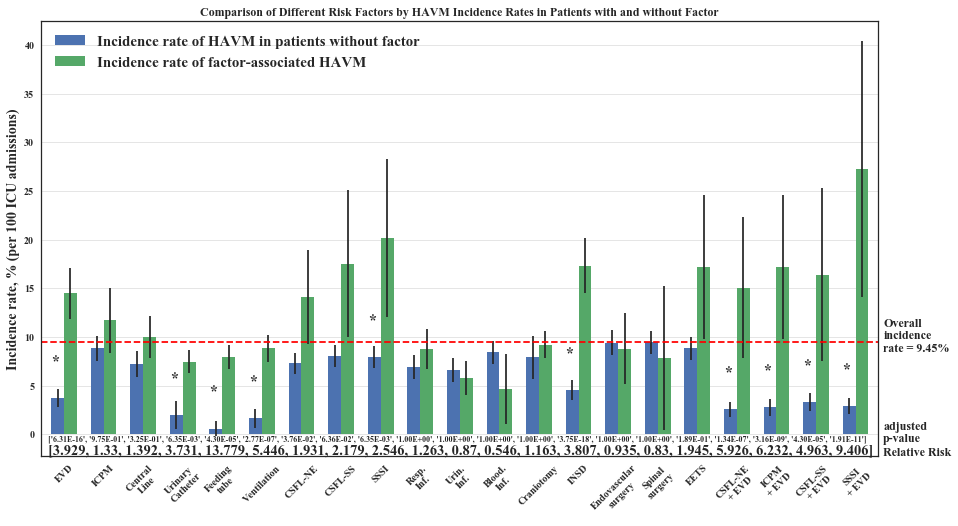

In [27]:
# Plot incidence by factors

palette = sns.color_palette()

######## Names
ticks = ["EVD", 'ICPM', 'Central\nLine', 'Urinary\nCatheter', 'Feeding\ntube',
         'Ventilation', 'CSFL-NE', 'CSFL-SS', 'SSSI', 'Resp.\nInf.', 'Urin.\nInf.', 'Blood.\nInf.',
         'Craniotomy', 'INSD', 'Endovascular\nsurgery', 'Spinal\nsurgery', 'EETS',
         'CSFL-NE\n+ EVD', 'ICPM\n+ EVD', 'CSFL-SS\n+ EVD', 'SSSI\n+ EVD']

idx = ('Incidence rate of HAVM in patients without factor', 'Incidence rate of factor-associated HAVM')


######## Data to plot
a = pd.concat([incidence, combined], axis=1)
a = a.rename(index={'Incidence NO factor': 'Incidence rate of HAVM in patients without factor',
                'Incidence with factor': 'Incidence rate of factor-associated HAVM'})

p_adjusted = multitest.multipletests(a.T['p-value'], alpha=0.05, method='holm')[1]

p = []
for i in p_adjusted:
    p.append('%.2E' % Decimal(i))

from math import ceil, floor
def float_round(num, places = 0, direction = floor):
    return direction(num * (10**places)) / float(10**places)

RR = []
for i in np.array(a.T['Relative risk'].values):
    RR.append(float_round(i, 3) )
    
############ Plot
ci0 = a.loc['CI, incidence NO factor', :]
i0 = a.loc['Incidence rate of HAVM in patients without factor', :]

ci1 = a.loc['CI, incidence with factor',:]
i1 = a.loc['Incidence rate of factor-associated HAVM', :]

# To matrix 
ci0 = [[val - eval(ci)[0] * 100, eval(ci)[1] * 100 - val] for ci, val in zip(ci0.values, i0.values)]
ci1 = [[val - eval(ci)[0] * 100, eval(ci)[1] * 100 - val] for ci, val in zip(ci1.values, i1.values)]

ci0 = np.array(ci0)
ci1 = np.array(ci1)


# We have to swap axes: (2,21,2) -> (2,2,21)
ci = np.array([ci0, ci1])
ci = ci.swapaxes(1,2)


fig, ax = plt.subplots()
bars = a.loc[idx, :].T.plot(kind='bar',
                   figsize=(15, 8),
                   width=0.65,
                   yerr=ci,
                   ax=ax)

ax.set_xticklabels(ticks, rotation=45.)

# Put stars
rects = ax.patches

# Now make some labels
labels = ["*" if float(val) < 1e-2 else "" for val in p]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() +0.1, height + 3, label, ha='center', va='bottom', size=16)

# 
plt.ylabel('Incidence rate, % (per 100 ICU admissions)', size=14)
plt.title('Comparison of Different Risk Factors by HAVM Incidence Rates in Patients with and without Factor')
plt.grid(b=True, which='major', axis='y',alpha=0.5)
####### Add text
plt.axhline(y=9.45, color='r', linestyle='--')
plt.text(20.7, 8.5,'Overall\nincidence\nrate = 9.45%')
plt.text(-0.4, -0.7, p, size=8)
plt.text(20.7, -0.8, 'adjusted\np-value', size=12)
plt.text(-0.4, -2.0, RR, size=14.5)
plt.text(20.7, -2.2, 'Relative Risk', size=12)
plt.legend(loc='upper left', prop={'size': 15})


plt.savefig('./final_plots/incidence_all.pdf', dpi=600)

____________